# Market Prediction

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

In this project, a model to predict the house-prices of the Philadelphia metropolitan areas in U.S. is implemented.

## Data onboarding

Initialize libraries

In [227]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL


figs_dir = "./figures"
figs_dir = figs_dir if os.path.isdir(figs_dir) else ""

Fetch the data from the kaggle API (saved as a local file)

In [228]:
# Fetch the latest version of the dataset from kaggle
# Requires authentication

data_dir = kagglehub.competition_download('hull-tactical-market-prediction')
data_path = os.path.join(data_dir, "train.csv")

Load the data from the local file

In [229]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())

(9021, 98)
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]


---

## Data visualization and exploratory analysis

The time-series dataset consists of 9021 samples with 98 variables. The variables are

- `date_id`: An identifier for a single trading day.

- `M*`: Market Dynamics/Technical features.

- `E*`: Macro Economic features.

- `I*`: Interest Rate features.

- `P*`: Price/Valuation features.

- `V*`: Volatility features.

- `S*`: Sentiment features.

- `MOM*`: Momentum features.

- `D*`: Dummy/Binary features.

- `forward_returns`: The returns from buying the S&P 500 and selling it a day later.

- `risk_free_rate`: The federal funds rate. 

- `market_forward_excess_returns`: Forward returns relative to expectations. Computed by subtracting the rolling five-year mean forward returns and winsorizing the result using a median absolute deviation (MAD) with a criterion of 4.


In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                            8015 non-null   f

There is plenty of missing data; most variables have over a thousand `null` values.

The predicted feature is `forward_returns`. Plotting the predicted variables over time

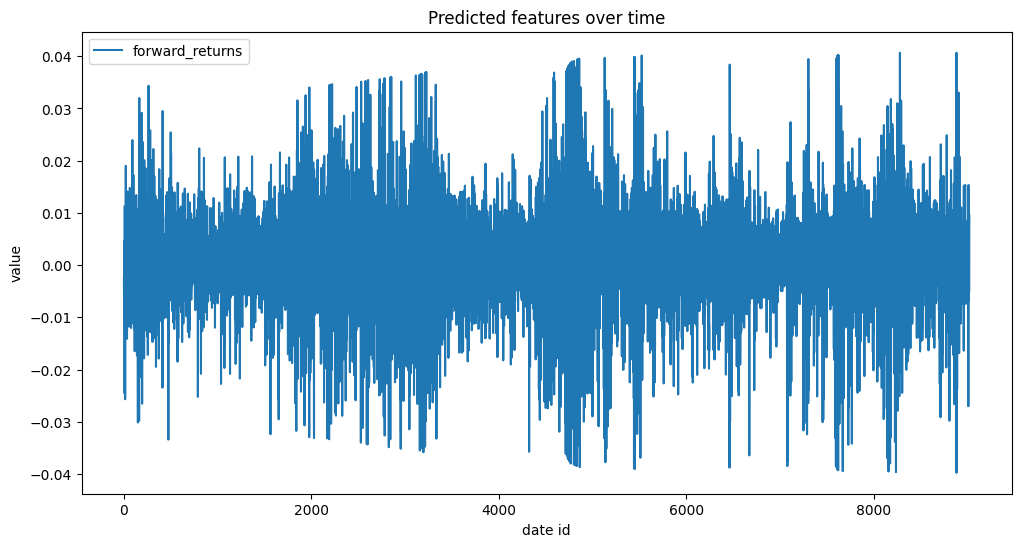

In [231]:
plt.figure(figsize=(12,6))
for f in ['forward_returns']:
    plt.plot(data['date_id'], data[f], label=f)
plt.title('Predicted features over time')
plt.legend(loc='upper left')
plt.xlabel("date id")
plt.ylabel("value")
if figs_dir: plt.savefig(os.path.join(figs_dir, "forward_returns.png"))
plt.show()

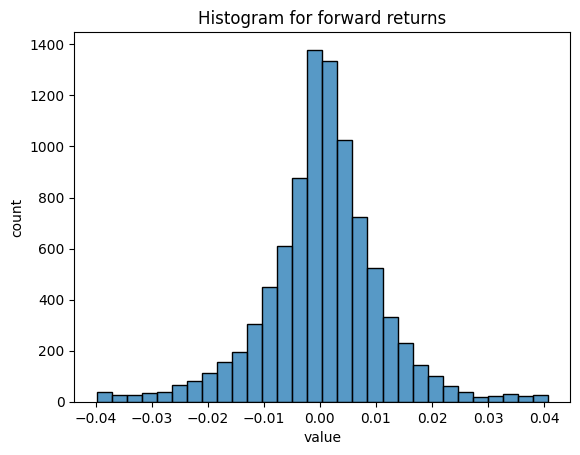

In [232]:
sns.histplot(data['forward_returns'], bins=30)
plt.title("Histogram for forward returns")
plt.xlabel("value")
plt.ylabel("count")
if figs_dir: plt.savefig(os.path.join(figs_dir, "forward_returns_hist.png"))
plt.show()

The correlation matrix of the data

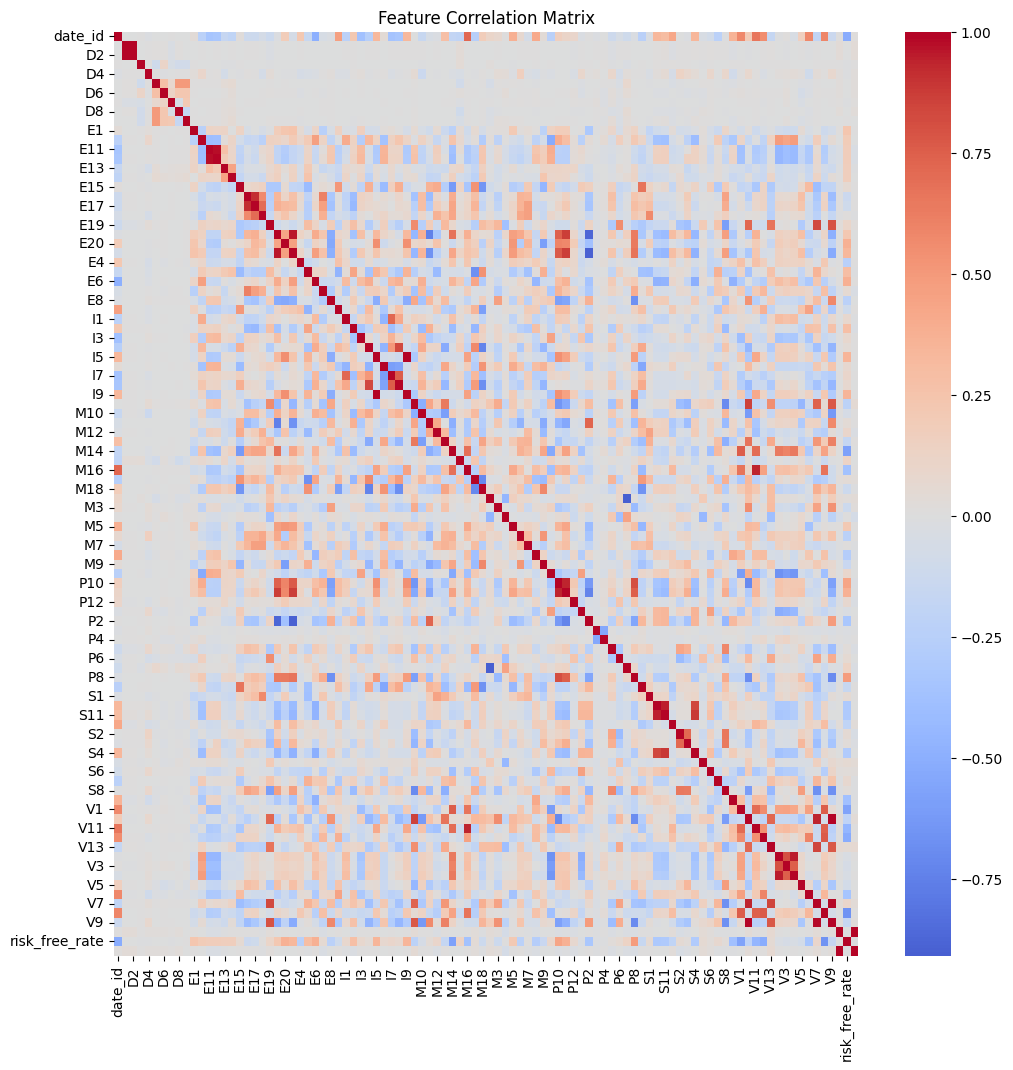

In [233]:
corr = data.corr()

plt.figure(figsize=[12, 12])
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
if figs_dir: plt.savefig(os.path.join(figs_dir, "corr_matrix.png"))
plt.show()

There are few stronger correlations in the data, most of the variables do not correlate with the predicted variables or other variables strongly. 

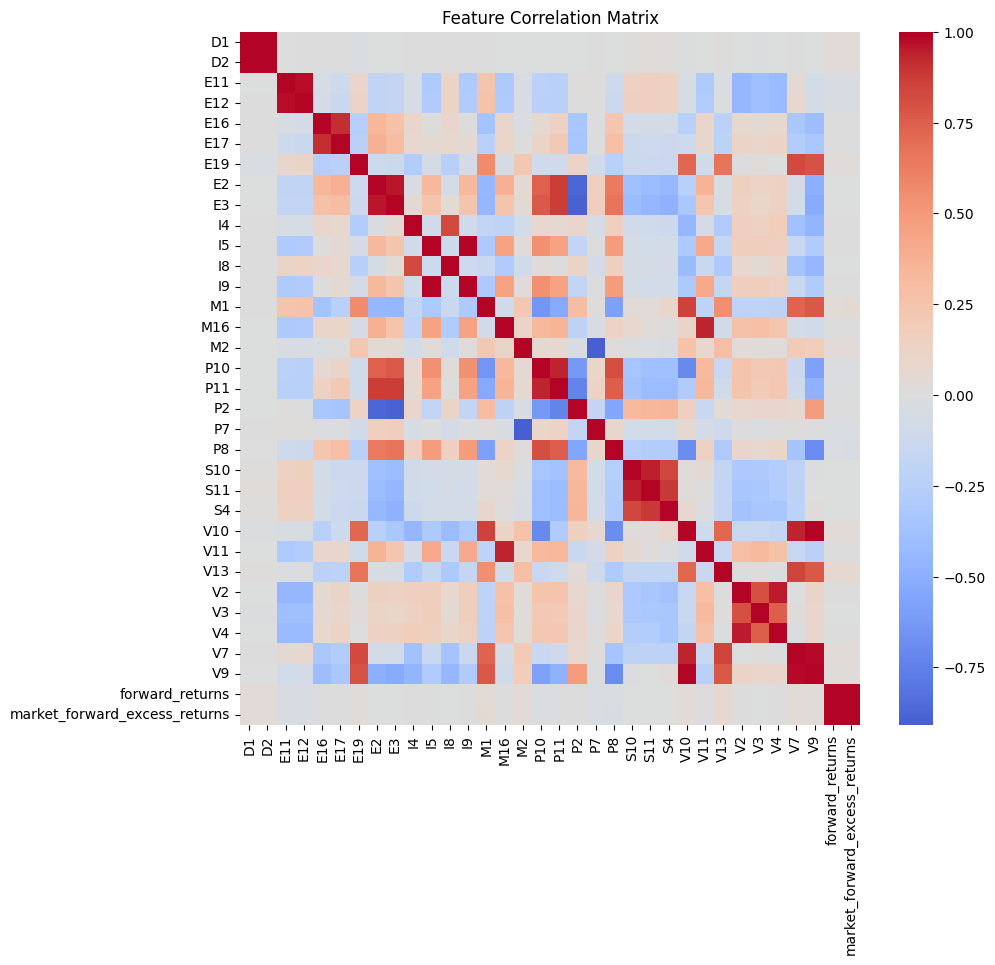

In [234]:
level = 0.8
idx = (np.max(np.abs(corr-np.eye(len(corr))), axis=0) > level).to_numpy()
strong_corr = corr.iloc[idx, idx]

plt.figure(figsize=(10, 9))
sns.heatmap(strong_corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
if figs_dir: plt.savefig(os.path.join(figs_dir, "strong_corr_matrix.png"))
plt.show()

---

## Time-series decomposition analysis

Based on the figure of the forward returns above, it seems that the time series to predict does not contain any long-term trend. The time series seems more like a heteroscedastic Gaussian stochastic process. Next we study whether the forward returns time series contain any short-term patterns.

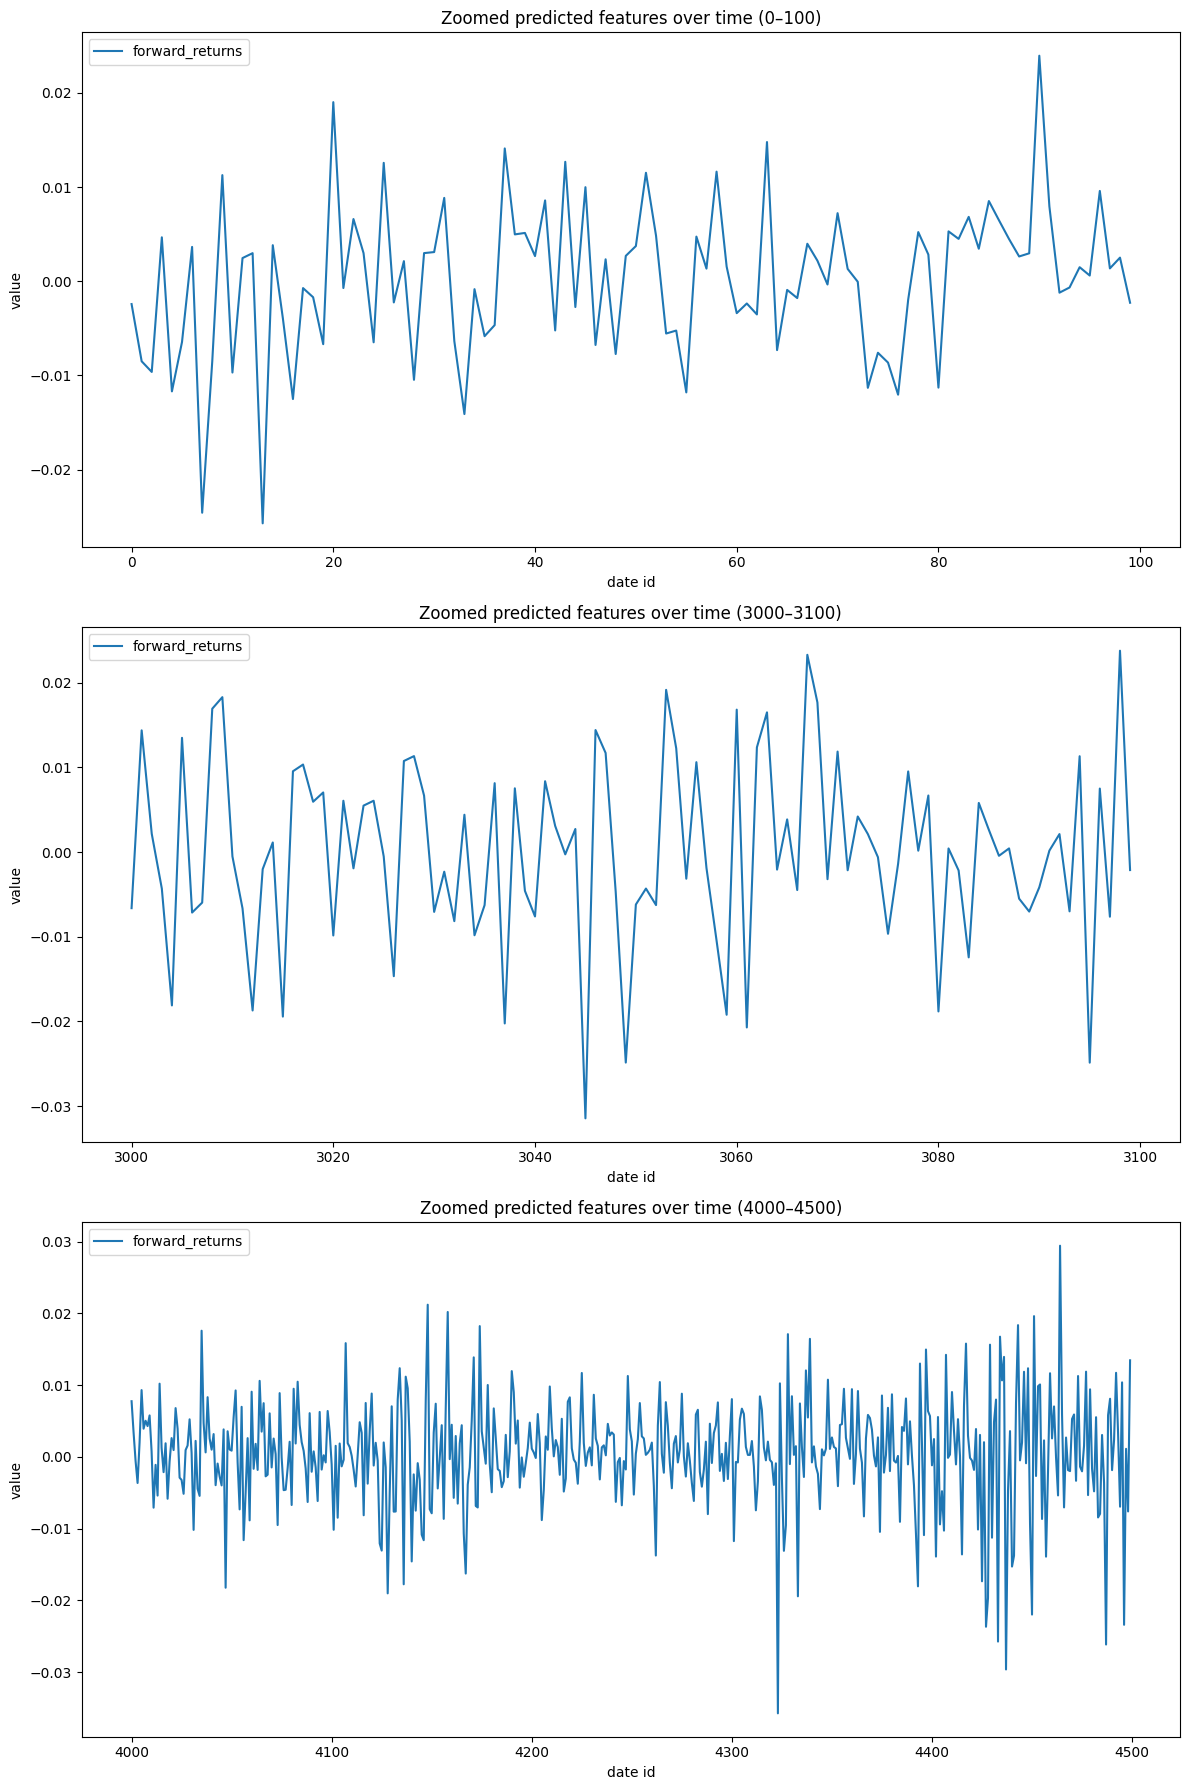

In [235]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

start_ind, end_ind = 0, 100
axes[0].plot(data['date_id'][start_ind:end_ind], data['forward_returns'][start_ind:end_ind], label='forward_returns')
axes[0].set_title('Zoomed predicted features over time (0–100)')
axes[0].legend(loc='upper left')
axes[0].set_xlabel("date id")
axes[0].set_ylabel("value")

start_ind, end_ind = 3000, 3100
axes[1].plot(data['date_id'][start_ind:end_ind], data['forward_returns'][start_ind:end_ind], label='forward_returns')
axes[1].set_title('Zoomed predicted features over time (3000–3100)')
axes[1].legend(loc='upper left')
axes[1].set_xlabel("date id")
axes[1].set_ylabel("value")

start_ind, end_ind = 4000, 4500
axes[2].plot(data['date_id'][start_ind:end_ind], data['forward_returns'][start_ind:end_ind], label='forward_returns')
axes[2].set_title('Zoomed predicted features over time (4000–4500)')
axes[2].legend(loc='upper left')
axes[2].set_xlabel("date id")
axes[2].set_ylabel("value")

# Adjust layout so titles/labels don’t overlap
plt.tight_layout()
plt.savefig("zoomed_forward_returns_plot.pdf")
plt.show()

It seems that the time series does not contain any clear long-term or short-term linear trend or seasonal pattern. Let's fit a linear regression to confirm that no linear trend exist.

In [236]:
len_ts = len(data['forward_returns'])
X = np.array([data['forward_returns'].index, np.ones(len_ts)]).T
y = np.array(data['forward_returns'].values).T
coefs = np.linalg.inv(X.T @ X) @ X.T @ y
print("Linear regression coefficients: ", coefs)

Linear regression coefficients:  [1.98082307e-08 3.82116136e-04]


Since the coefficients $\approx 0$ -> no long-term trend

As a conclusion, the time series to predict does not have any long-term trend or seasonal component.

---

## Autocorrelation analysis

In [237]:
y = data['forward_returns']

### Correlation matrix of lags

In [238]:

# Create lagged dataset
df = pd.concat([y.shift(3), y.shift(2),
                y.shift(1), y], axis=1)

# Set column names
df.columns = ['t', 't+1', 't+2', 't+3']

res = df.corr()
print(res)

            t       t+1       t+2       t+3
t    1.000000 -0.044883 -0.017137 -0.017240
t+1 -0.044883  1.000000 -0.044839 -0.017087
t+2 -0.017137 -0.044839  1.000000 -0.044766
t+3 -0.017240 -0.017087 -0.044766  1.000000


### Calculation of residuals

In [239]:
# Checking the residuals for autocorrelation
# Fit a simple OLS model with 1-lag to get residuals
y_lag1 = y.shift(1)

# Creating DataFrame and dropping NaN values
df = pd.DataFrame({"y": y, "y_lag1": y_lag1}).dropna()
# Adding intercept with the lagged variable
X = sm.add_constant(df["y_lag1"])

# Fit the model to predict y using y_lag1
model = sm.OLS(df["y"], X).fit()
# Get the residuals of this prediction
resid = model.resid


### Autocorrelation plots

Text(0.5, 1.0, 'Lag plot: |residuals| (lag=1)')

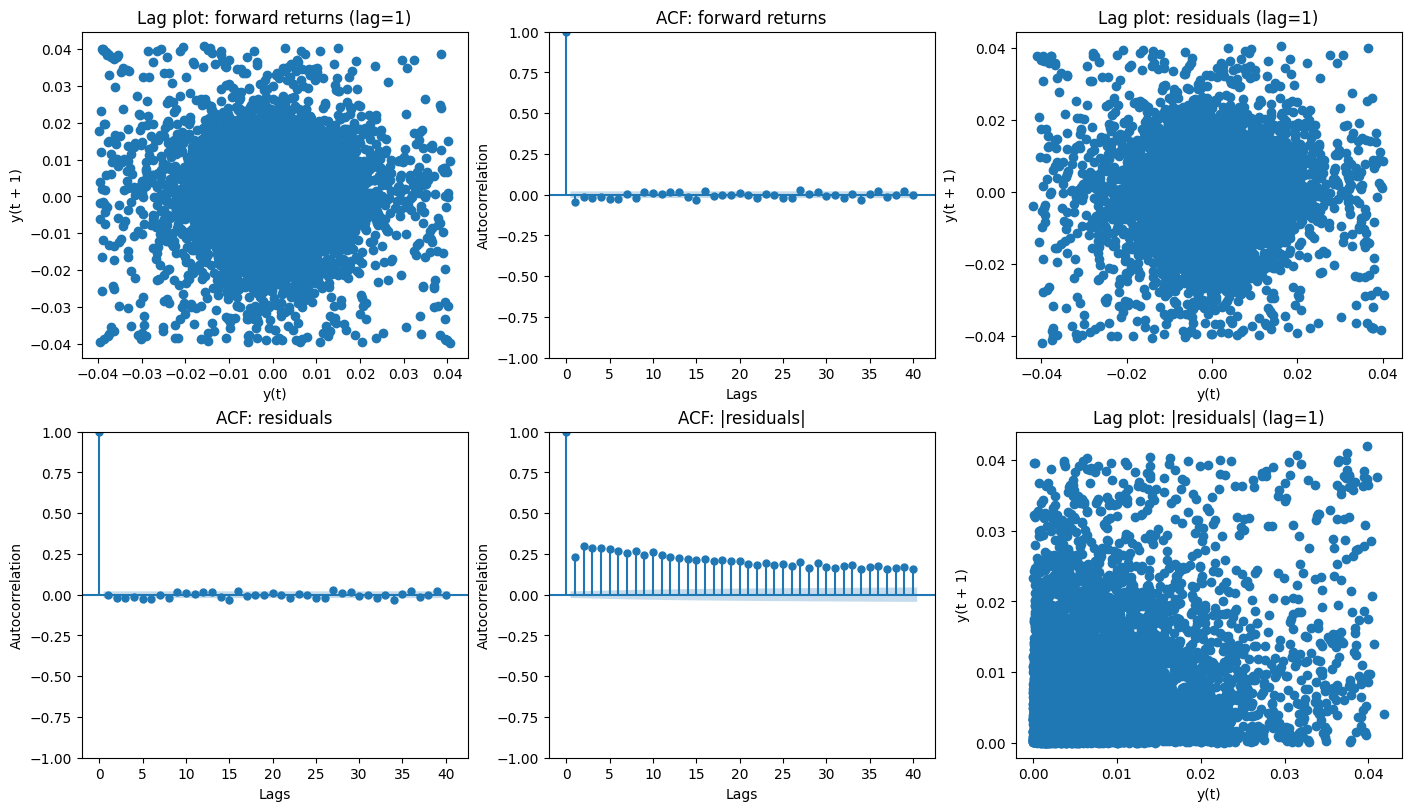

In [240]:
y = y.dropna()
resid  = resid.dropna()

fig, axes = plt.subplots(2, 3, figsize=(14, 8),constrained_layout=True)

# Lag plot of target
pd.plotting.lag_plot(y, lag=1, ax=axes[0, 0])
axes[0, 0].set_title("Lag plot: forward returns (lag=1)")

# ACF of target
plot_acf(y, lags=40, ax=axes[0, 1])
axes[0, 1].set_title("ACF: forward returns")
axes[0, 1].set_xlabel("Lags")
axes[0, 1].set_ylabel("Autocorrelation")

# Lag plot of residuals
pd.plotting.lag_plot(resid, lag=1, ax=axes[0, 2])
axes[0, 2].set_title("Lag plot: residuals (lag=1)")

# ACF of residuals
plot_acf(resid, lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF: residuals")
axes[1, 0].set_xlabel("Lags")
axes[1, 0].set_ylabel("Autocorrelation")

# ACF of |residuals|
plot_acf(abs(resid), lags=40, ax=axes[1, 1])
axes[1, 1].set_title("ACF: |residuals|")
axes[1, 1].set_xlabel("Lags")
axes[1, 1].set_ylabel("Autocorrelation")

# Lag plot of |residuals|
pd.plotting.lag_plot(abs(resid), lag=1, ax=axes[1, 2])
axes[1, 2].set_title("Lag plot: |residuals| (lag=1)")

---

## Partitioning the time-series data

In [241]:
# Possible function to use for splitting
# from sklearn.model_selection import TimeSeriesSplit

## Plotting missing features

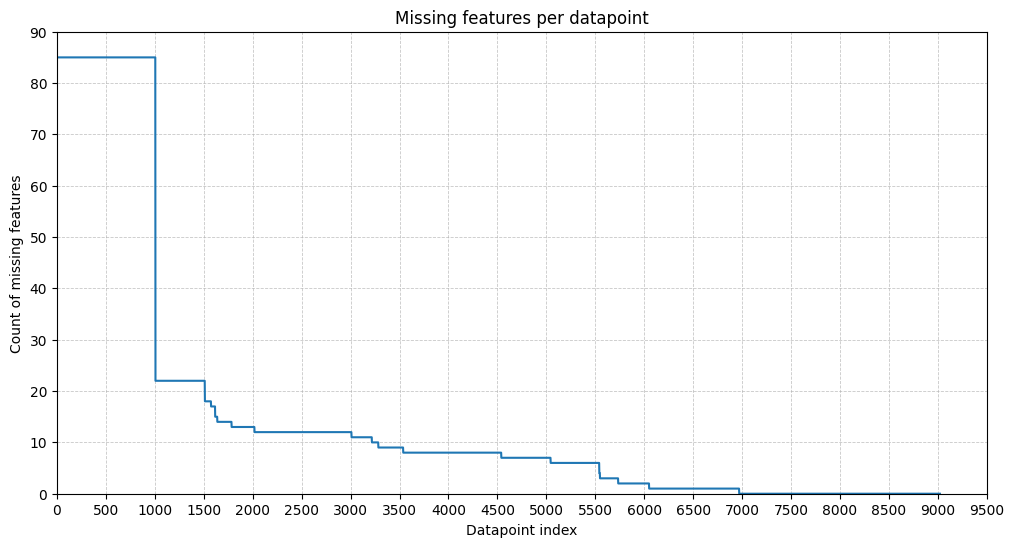

In [242]:
# Searching for the missing values
# Count missing values per row
missing_per_row = data.isnull().sum(axis=1)

plt.figure(figsize=(12,6))
plt.plot(missing_per_row)
plt.title("Missing features per datapoint")
plt.xlabel("Datapoint index")
plt.ylabel("Count of missing features")
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
plt.xlim(0, 9500)
plt.ylim(0, 90)
plt.xticks(np.arange(0, 9501, 500))
plt.yticks(np.arange(0, 91, 10))
if figs_dir: plt.savefig(os.path.join(figs_dir, "missing_features_per_datapoint.png"))
plt.show()


---

# Data pretreatment & baseline model

The time-series dataset consists of 9021 samples with 98 variables. The variables are

- `date_id`: An identifier for a single trading day.

- `M*`: Market Dynamics/Technical features.

- `E*`: Macro Economic features.

- `I*`: Interest Rate features.

- `P*`: Price/Valuation features.

- `V*`: Volatility features.

- `S*`: Sentiment features.

- `MOM*`: Momentum features.

- `D*`: Dummy/Binary features.

- `forward_returns`: The returns from buying the S&P 500 and selling it a day later.

- `risk_free_rate`: The federal funds rate. 

- `market_forward_excess_returns`: Forward returns relative to expectations. Computed by subtracting the rolling five-year mean forward returns and winsorizing the result using a median absolute deviation (MAD) with a criterion of 4.


## Continuity & synchronous

---

## Missing values & STL decomposition

In [286]:
# Skipping the missing values in the beginning of the time series and starting the data from day 1006, row 1008
data_resampled = data.iloc[1008:].reset_index(drop=True)
data_resampled = data_resampled.drop(columns=['risk_free_rate','market_forward_excess_returns'])
print(data_resampled.shape)

(8013, 96)


In [287]:
# Finding what data is missing the most entries
missing_counts = data_resampled.isnull().sum().sort_values(ascending=False)
print("Variables with missing values:", (missing_counts > 0).sum())

# Removing the variables from the dataset that have missing values
data_cleaned = data_resampled.loc[:, data_resampled.isnull().sum() == 0]
print(data_cleaned.shape) 

Variables with missing values: 22
(8013, 74)


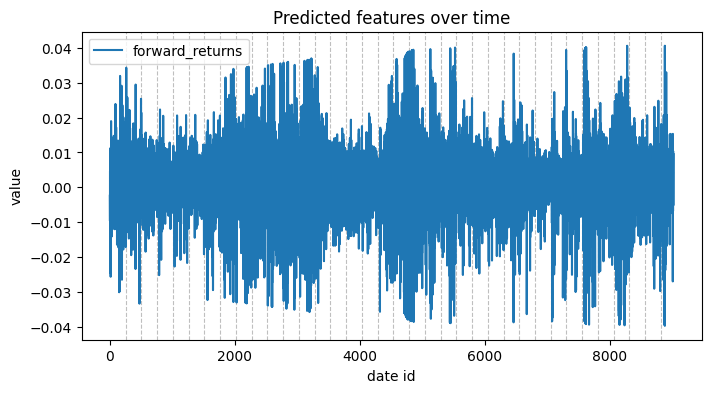

In [288]:
plt.figure(figsize=(8,4))

# Adding vertical lines every 252 entries
# Represents approximately one trading year
for i in range(252, len(data), 252):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)


for f in ['forward_returns']:
    plt.plot(data['date_id'], data[f], label=f)
plt.title('Predicted features over time')
plt.legend(loc='upper left')
plt.xlabel("date id")
plt.ylabel("value")
plt.show()

Text(0, 0.5, 'value')

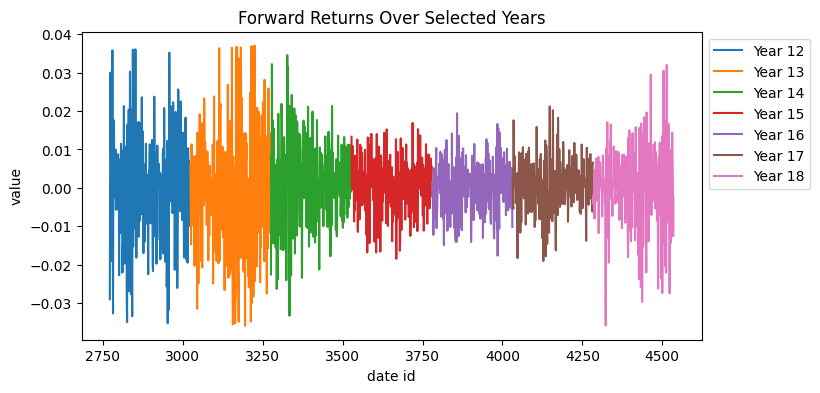

In [289]:
# Plotting a few years form the middle to see if there are visible trends
years_to_plot = [11, 12, 13, 14, 15, 16, 17]
plt.figure(figsize=(8,4))
for year in years_to_plot:
    start_idx = year * 252
    end_idx = start_idx + 252
    plt.plot(data['date_id'][start_idx:end_idx], data['forward_returns'][start_idx:end_idx], label=f'Year {year+1}')    
plt.title('Forward Returns Over Selected Years')
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
plt.xlabel("date id")
plt.ylabel("value")

### STL

code source: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb

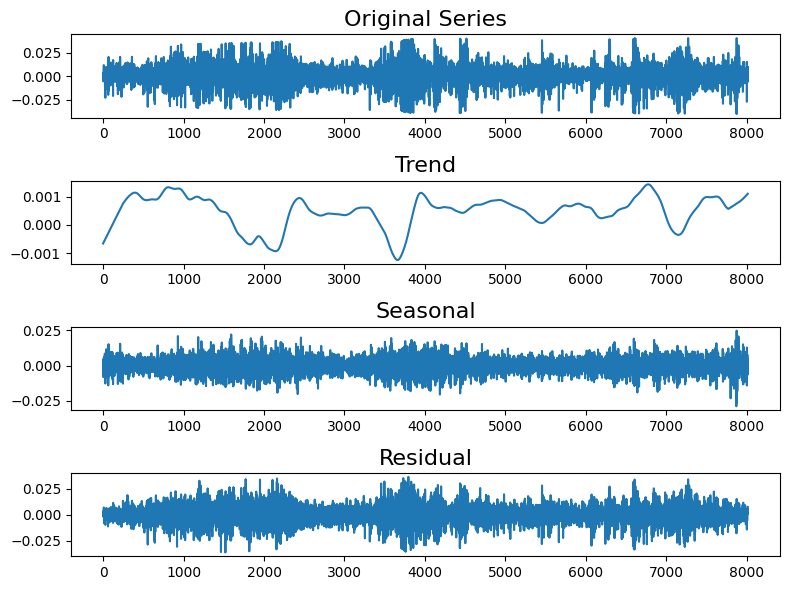

In [290]:
# Doing STL with yearly seasonality (252 trading days)
returns = data_cleaned['forward_returns']
stl = STL(returns, period=252)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(returns)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

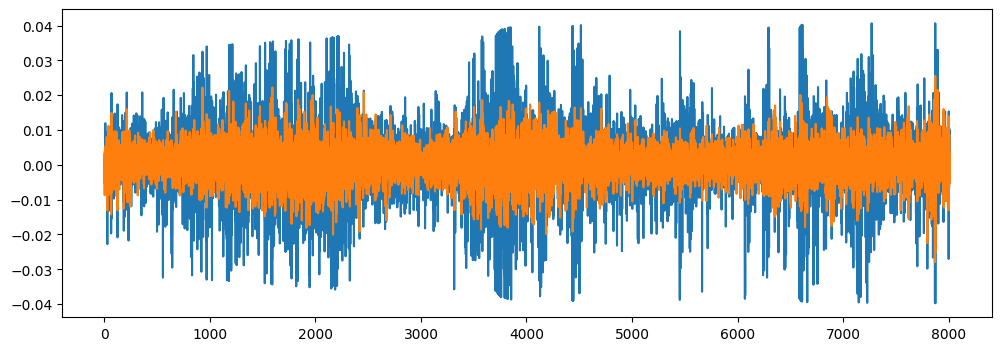

In [291]:
# Estimating the original series from trend and seasonal components
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(returns, label='Original')
plt.plot(estimated)

C:\Users\matti\AppData\Local\Temp\ipykernel_29484\811517510.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


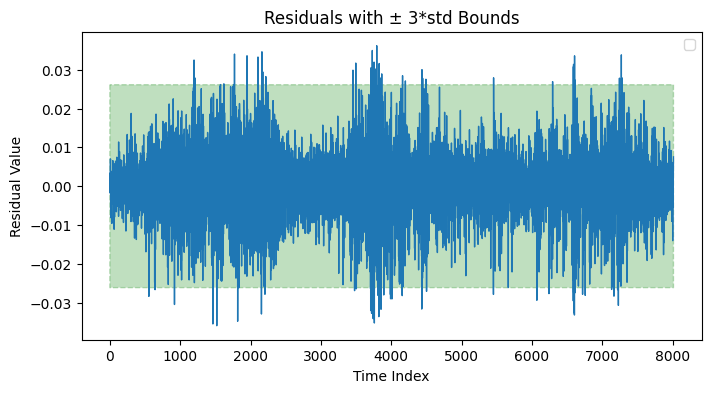

In [292]:
# Calculate residual bounds with 3 standard deviations
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

# Plot residuals with bounds
plt.figure(figsize=(8, 4))
plt.plot(resid.values, linewidth=1)
plt.fill_between(range(len(resid)), lower, upper, color='green',linestyle='--', alpha=0.25)
plt.title('Residuals with ± 3*std Bounds')
plt.xlabel('Time Index')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

Number of anomalies detected: 97
Percentage of anomalies: 1.21%


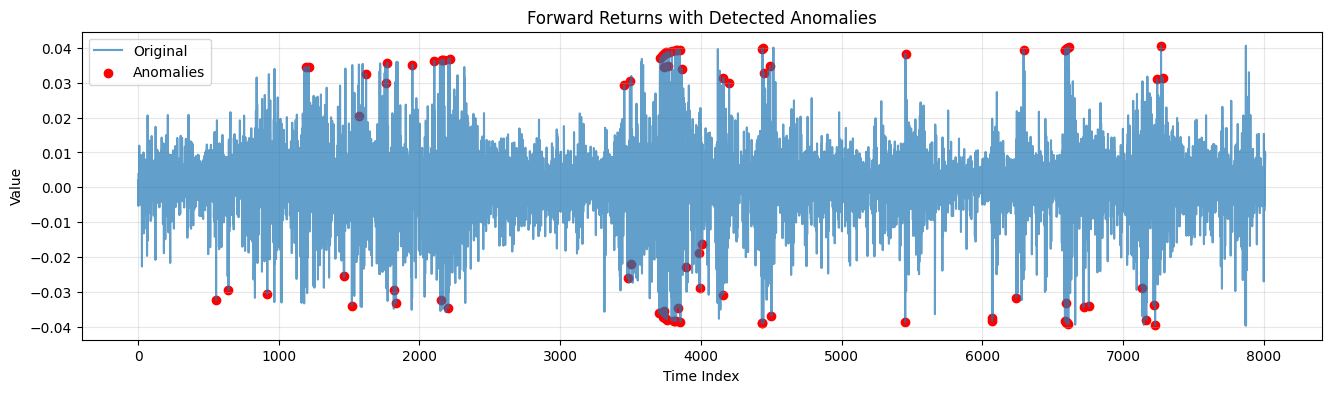

In [293]:
# Identifying anomalies from the residuals
anomalies = resid[(resid < lower) | (resid > upper)]
anomaly_percentage = round(100*len(anomalies)/len(resid),2)

print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Percentage of anomalies: {anomaly_percentage}%")

# Plotting the original data, with the previous anomalies highlighted
plt.figure(figsize=(16, 4))
plt.plot(returns.values, label='Original', alpha=0.7)
anomaly_indices = anomalies.index

# Plotting the anomalies on top of the original data in the corresponding positions
plt.scatter(anomaly_indices, returns.iloc[anomaly_indices], color='r', marker='o', label='Anomalies')
plt.title('Forward Returns with Detected Anomalies')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [298]:
anomalies

555    -0.028402
643    -0.026681
919    -0.030502
1197    0.032520
1213    0.027863
          ...   
7218   -0.026672
7229   -0.030728
7244    0.027844
7271    0.033846
7284    0.027890
Name: resid, Length: 97, dtype: float64

---

## Baseline model

---

## Dimensionality reduction

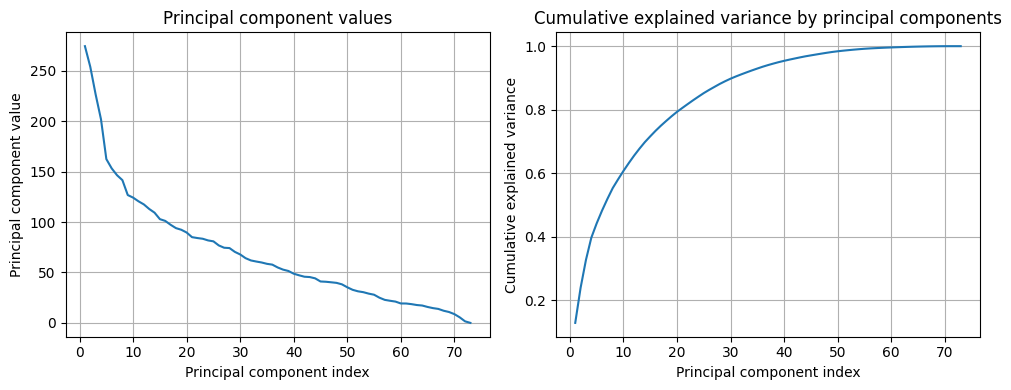

In [295]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

# Split data to X and y
predicted = "forward_returns"
features = [f for f in data_cleaned.columns if f != predicted]
X, y = data_cleaned[features], data_cleaned[predicted]

# Apply PCA to scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=X_scaled.shape[-1])
with warnings.catch_warnings(action="ignore"):
    X_pca = pca.fit_transform(X_scaled)

# Plot principal component values and cumulative explained variance as subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(np.arange(1, len(pca.components_) + 1), pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component index")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(np.arange(1, len(pca.components_)  + 1), pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance by principal components")
axs[1].set_xlabel("Principal component index")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
plt.show()

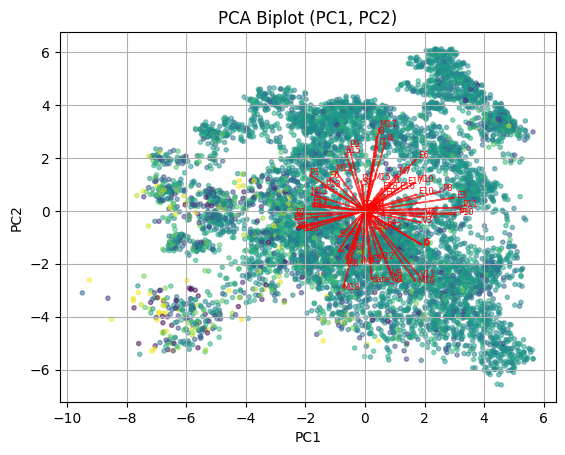

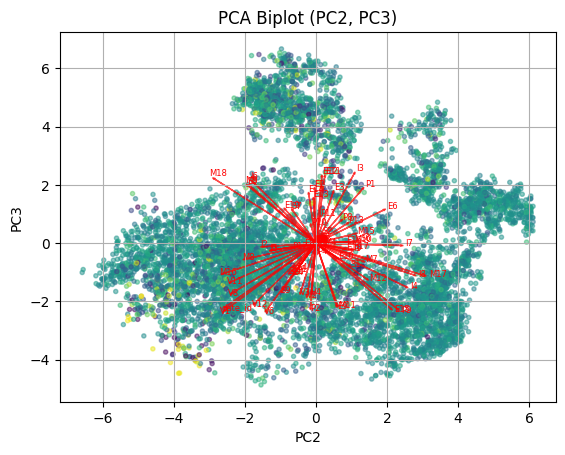

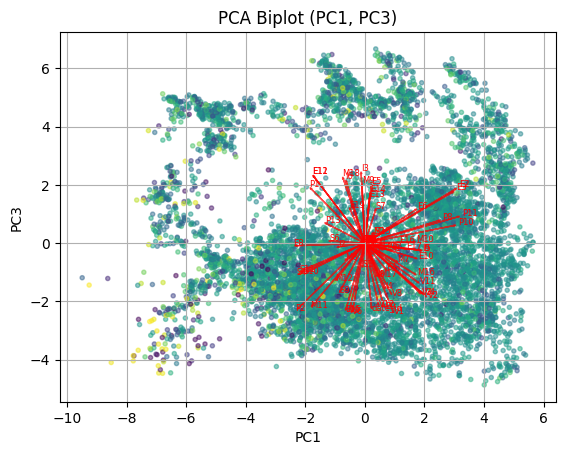

In [296]:
from itertools import combinations

# Get loadings
loadings = pca.components_.T * np.max(np.abs(X_pca)) #np.sqrt(pca.explained_variance_) * np.

# Choose the number of principal components to plot
PC_combinations = [(0, 1), (1, 2), (0, 2)]

# Plots for each combination of principal components
for (i, j) in PC_combinations:

    # Plot datapoints
    plt.scatter(X_pca[:, i], X_pca[:, j], marker='.', alpha=0.5, label="Samples", c=y)

    # Plot arrows for loadings
    for k, feature in enumerate(X.columns):
        u, v = loadings[k, i], loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    plt.grid()
    plt.show()

### Dimensionality using t-SNE



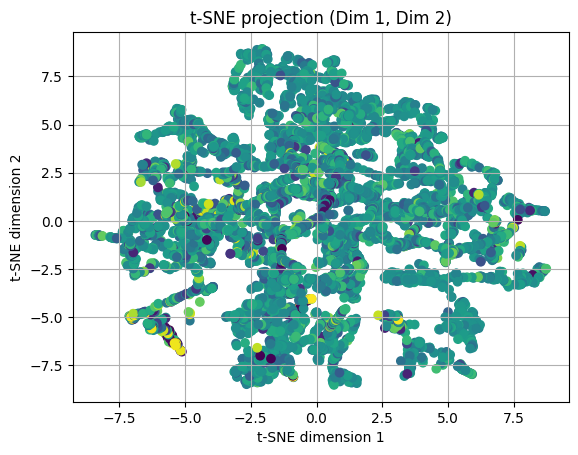

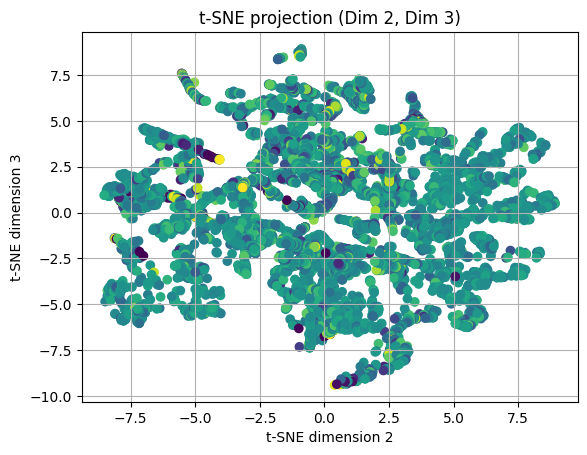

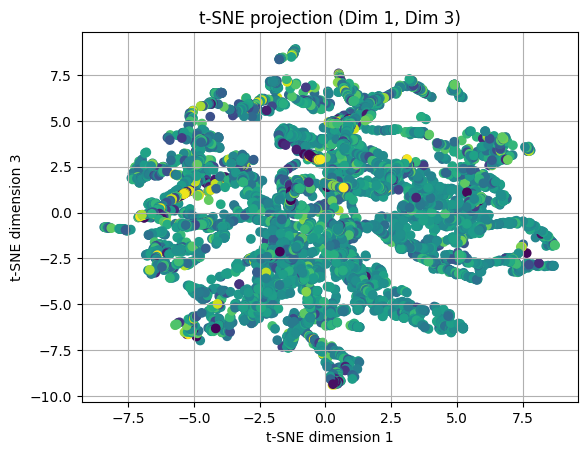

In [297]:
from sklearn.manifold import TSNE
import warnings

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize t-SNE
tsne = TSNE(n_components=3, perplexity=30, max_iter=300, random_state=0)

# Apply t-SNE to the data
with warnings.catch_warnings(action='ignore'):
    X_tsne = tsne.fit_transform(X_scaled)

tsne_combinations = [(0, 1), (1, 2), (0, 2)]

for (i, j) in tsne_combinations:
    # Visualize t-SNE
    plt.scatter(X_tsne[:, i], X_tsne[:, j], c=y)
    plt.xlabel(f"t-SNE dimension {i+1}")
    plt.ylabel(f"t-SNE dimension {j+1}")
    plt.title(f"t-SNE projection (Dim {i+1}, Dim {j+1})")
    plt.grid()
    plt.show()